In [1]:
import torch
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:256'

In [2]:
torch.cuda.is_available(), torch.cuda.device_count()

(True, 1)

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [4]:
import torchvision

train = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, 
                                   transform=transforms.ToTensor())
test = torchvision.datasets.MNIST(root='./mnist-test', train=False,
                                        download=True, 
                                  transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]))

In [5]:
from pathlib import Path

In [6]:
i = 0
dirname = 'mnist-infl'

In [ ]:
def get_test_probs(model):
    model.to(device)
    model.eval()
    with torch.no_grad():
        X = test.data.view(-1, 1, 28, 28).float().to(device)
        Y = test.targets.to(device)

        logits = model(X)
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        return probs[torch.arange(X.shape[0]), Y]

# Let's aggregate the influence functions

In [ ]:
batch_size = 10*1000
for lower in tqdm(range(0, 60000, batch_size), position=0):
    lower, upper = lower, lower + batch_size

    estimates_with = torch.zeros((batch_size, 60000))
    estimates_without = torch.zeros((batch_size, 60000))
    num_with = torch.zeros(batch_size)

    for i in tqdm(range(101), position=1, leave=False):
        d = torch.load(Path(dirname) / f'{i}')
        probs = d['probs']

        subset_idx = d['indexes']
        subset_idx = subset_idx.sort().values.unique()
        subset_idx = subset_idx - lower
        subset_idx = subset_idx[(subset_idx < batch_size) & (subset_idx >= 0)]
        
        subset_mask = torch.zeros(batch_size, dtype=torch.int64)
        subset_mask[subset_idx] = 1

        num_with[subset_mask.bool()] += 1
        
        estimates_with[subset_idx] += probs
        estimates_without[subset_mask.bool() == False] += probs
        
    path =  Path(dirname) / f'agg_{lower}_{upper - 1}'
    print(path)
    torch.save({
        'estimates_with': estimates_with,
        'estimates_without': estimates_without,
        'num_with': num_with
    }, path)

# Let's look at memory

In [7]:
mem = torch.tensor(data=[])

batch_size = 10 * 1000
for lower in tqdm(range(0, 60000, batch_size), position=0):
    lower, upper = lower, lower + batch_size
    
    d = torch.load(Path(dirname) / f'agg_{lower}_{upper -1}')
    
    estimates_with = d['estimates_with']
    estimates_without = d['estimates_without']
    num_with = d['num_with']
    
    estimates_with = (estimates_with.T / num_with).T
    estimates_without = (estimates_without.T / (101 - num_with)).T
    
    esimate_changes = estimates_with - estimates_without
    estimate_mem = torch.diag(esimate_changes, 0)
    mem = torch.cat((mem, estimate_mem))

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
topk_val, topk_ind = mem.topk(10)
botk_val, botk_ind = (-mem).topk(10)
botk_val *= -1

/home/solnik/floor_plans/env/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


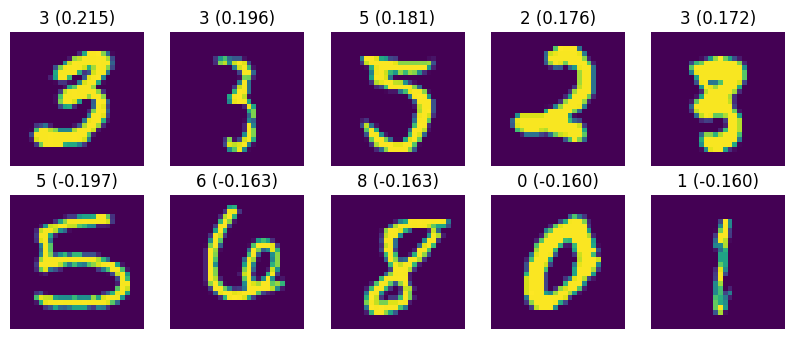

In [9]:
fig = plt.figure(figsize=(10, 6))
for idx in range(5):
    ax = fig.add_subplot(3, 5, idx+1)
    plt.imshow(train.data[topk_ind[idx]].squeeze(), )
    ax.set_title(f'{train.train_labels[topk_ind[idx]].item()} ({topk_val[idx].item():.3f})')
    ax.axis('off')
    
    ax = fig.add_subplot(3, 5, idx + 5 +1)
    plt.imshow(train.data[botk_ind[idx]].squeeze())
    ax.set_title(f'{train.targets[botk_ind[idx]].item()} ({botk_val[idx].item():.3f})')
    ax.axis('off')

In [10]:
mem_np = mem.numpy()

In [11]:
import seaborn as sns

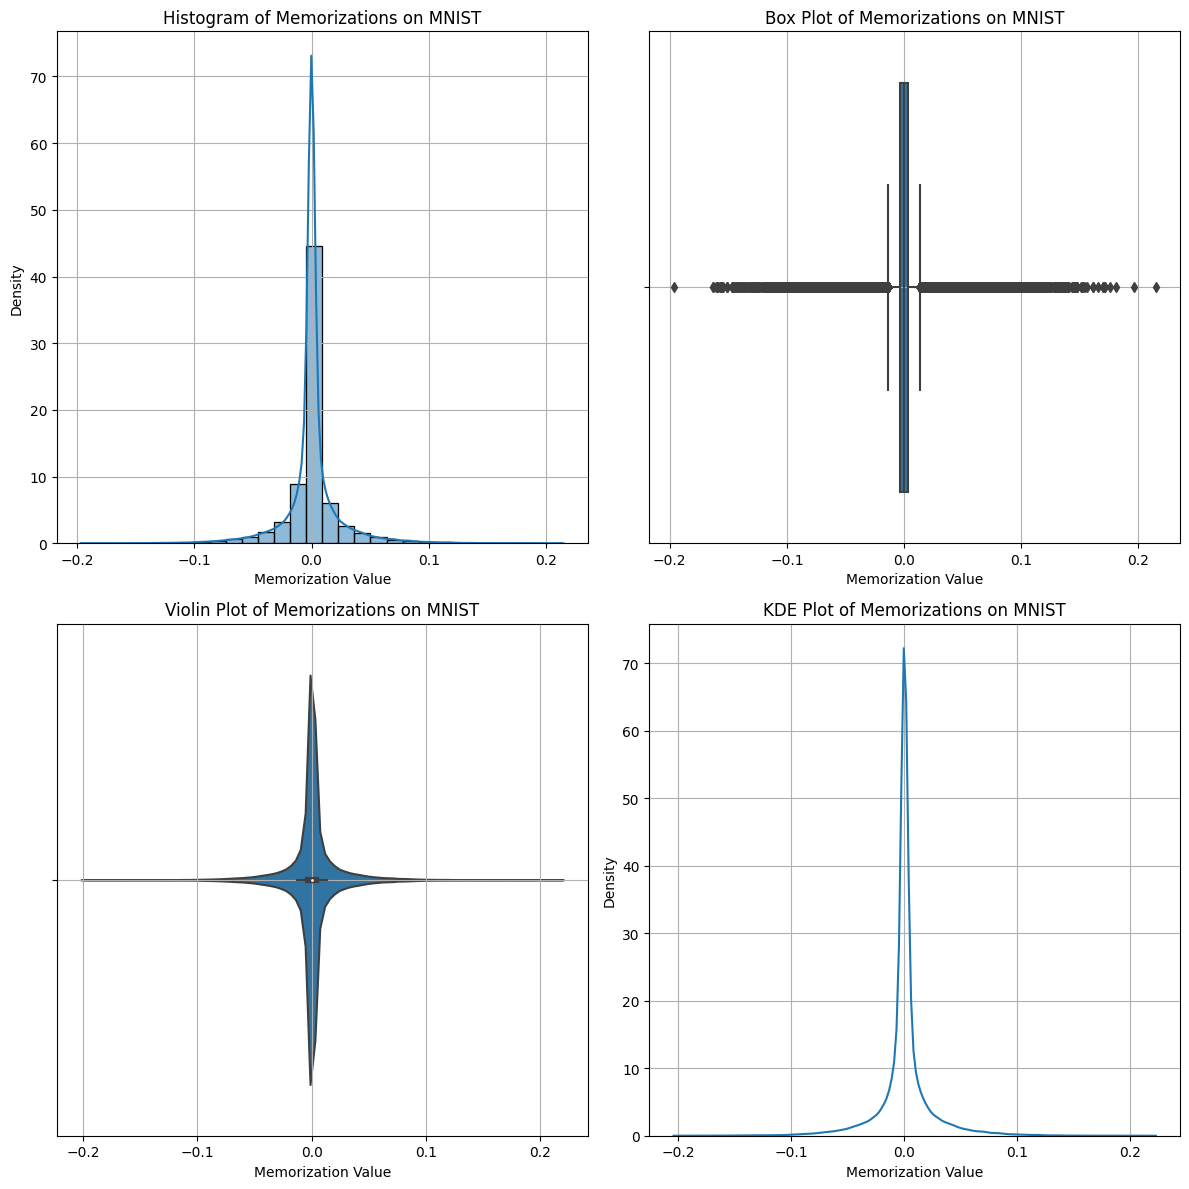

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming mem_np is a given NumPy array

# Define the common title part
title_common = "Memorizations on MNIST"

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.histplot(mem_np, bins=30, kde=True, stat='density', ax=axes[0, 0])
axes[0, 0].set_xlabel('Memorization Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Histogram of Memorizations on MNIST')
axes[0, 0].grid(True)

sns.boxplot(x=mem_np, ax=axes[0, 1])
axes[0, 1].set_xlabel('Memorization Value')
axes[0, 1].set_title(f'Box Plot of {title_common}')
axes[0, 1].grid(True)

sns.violinplot(x=mem_np, ax=axes[1, 0])
axes[1, 0].set_xlabel('Memorization Value')
axes[1, 0].set_title(f'Violin Plot of {title_common}')
axes[1, 0].grid(True)

sns.kdeplot(mem_np, ax=axes[1, 1])
axes[1, 1].set_xlabel('Memorization Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title(f'KDE Plot of {title_common}')
axes[1, 1].grid(True)


# Adjust the spacing between the subplots and display the combined plots
plt.tight_layout()
plt.show()

In [16]:
topk_values, topk_indices = torch.topk(esimate_changes.view(-1), k=10)

# Convert the 1D indices to 2D indices
topk_indices_2d = torch.stack([topk_indices // esimate_changes.shape[1], topk_indices % esimate_changes.shape[1]], dim=1)

In [17]:
topk_indices_2d

tensor([[ 5522, 36075],
        [ 4479,  7499],
        [    4, 49282],
        [ 1538, 45094],
        [  412, 57357],
        [ 3876,  6927],
        [ 7001, 56614],
        [ 2058,  6927],
        [ 6670, 46412],
        [ 1583,  6289]])

In [19]:
topk_indices_2d[0]

tensor([ 5522, 36075])

In [23]:
train.data.shape

torch.Size([60000, 28, 28])

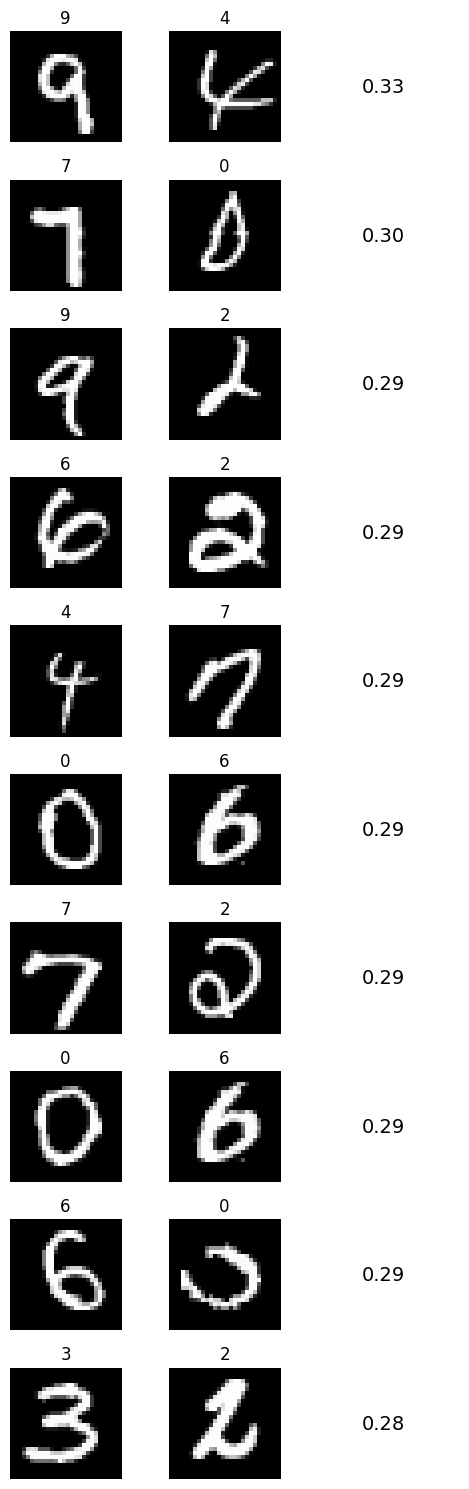

In [38]:
fig, axes = plt.subplots(10, 3, figsize=(5, 15))
for i, idx in enumerate(topk_indices_2d):
#     axes[i, 0].set_title(f'{idx[0].item()} {train.targets[idx[0]]}')
    axes[i, 0].set_title(f'{train.targets[idx[0]]}')
    axes[i, 0].imshow(train.data[idx[0]], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].set_title(f'{train.targets[idx[1]]}')
    axes[i, 1].imshow(train.data[idx[1]], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].text(0.5, 0.5, f'{topk_values[i]:.2f}', fontsize=14, ha='center', va='center')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

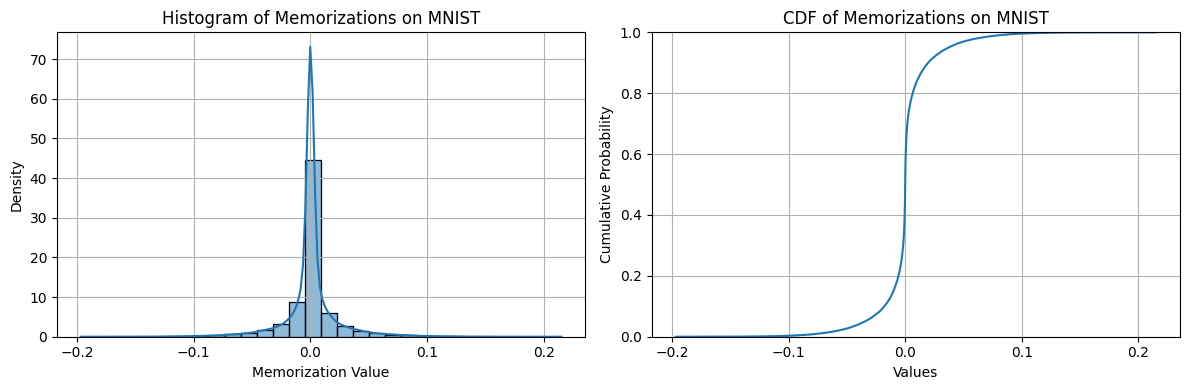

In [73]:
# Assuming mem_np is a given NumPy array

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First plot: Density histogram
sns.histplot(mem_np, bins=30, kde=True, stat='density', ax=axes[0])
axes[0].set_xlabel('Memorization Value')
axes[0].set_ylabel('Density')
axes[0].set_title('Histogram of Memorizations on MNIST')
axes[0].grid(True)

# Second plot: CDF
sns.ecdfplot(mem_np, ax=axes[1])
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('CDF of Memorizations on MNIST')
axes[1].grid(True)

# Display the combined plots
plt.tight_layout()
plt.show()

In [61]:
import numpy as np

In [65]:
from scipy.stats import cumfreq

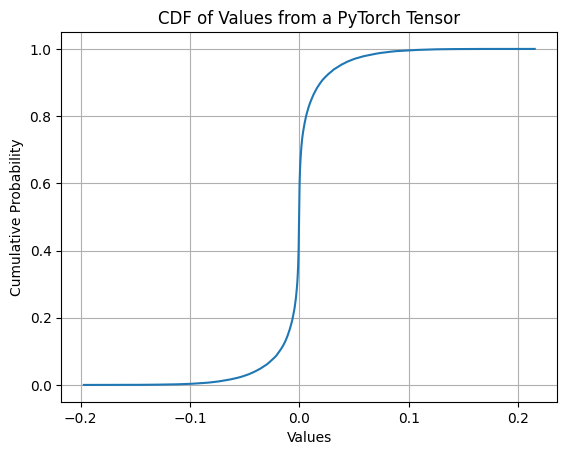

In [67]:
cumulative_frequency = cumfreq(mem_np, numbins=1000)
x_values = cumulative_frequency.lowerlimit + np.linspace(0, cumulative_frequency.binsize * cumulative_frequency.cumcount.size, cumulative_frequency.cumcount.size)

plt.plot(x_values, cumulative_frequency.cumcount / mem_np.size)
plt.xlabel('Values')
plt.ylabel('Cumulative Probability')  # Change the y-label to 'Cumulative Probability'
plt.title('CDF of Values from a PyTorch Tensor')
plt.grid(True)
plt.show()